In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

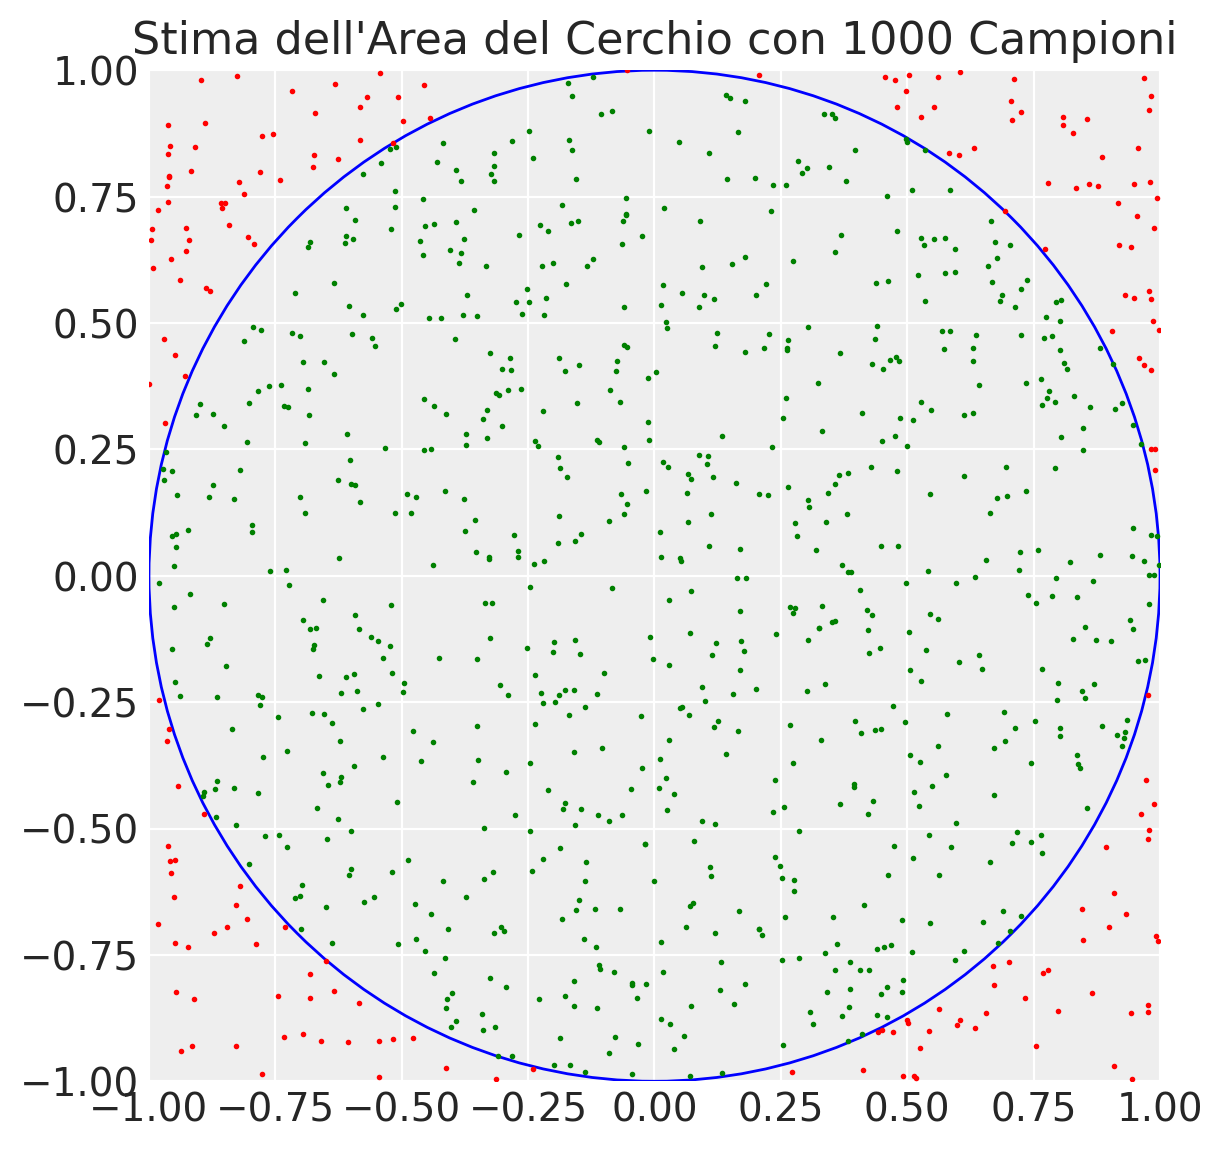

3.212

In [3]:
def monte_carlo_circle_area(samples):
    inside_circle = 0

    # Per la visualizzazione
    x_inside = []
    y_inside = []
    x_outside = []
    y_outside = []

    for _ in range(samples):
        x, y = np.random.uniform(-1, 1), np.random.uniform(-1, 1)  # Punti casuali nel quadrato
        distance = x**2 + y**2  # Distanza dal centro
        if distance <= 1:  # Se il punto è dentro il cerchio
            inside_circle += 1
            x_inside.append(x)
            y_inside.append(y)
        else:
            x_outside.append(x)
            y_outside.append(y)

    # Calcolo dell'area
    area_estimate = (inside_circle / samples) * 4

    # Visualizzazione
    fig, ax = plt.subplots(figsize=(6, 6))
    circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax.add_artist(circle)
    ax.scatter(x_inside, y_inside, color='green', s=1)
    ax.scatter(x_outside, y_outside, color='red', s=1)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_aspect('equal', adjustable='box')
    plt.title(f"Stima dell'Area del Cerchio con {samples} Campioni")
    plt.show()

    return area_estimate

# Test dell'algoritmo con 1000 campioni
estimated_area = monte_carlo_circle_area(1000)
estimated_area

In [4]:
moma_sample = pd.read_csv("../data/moma_sample.csv")

In [5]:
moma_sample.head()

,artist,country,birth,death,alive,genx,gender,count,year_acquired_min,year_acquired_max
0,Ad Gerritsen,dutch,1940,2015.0,False,False,male,1,1981,1981
1,Kirstine Roepstorff,danish,1972,NaN,True,True,female,3,2005,2005
2,Lisa Baumgardner,american,1958,2015.0,False,False,female,2,2016,2016
3,David Bates,american,1952,NaN,True,False,male,1,2001,2001
4,Simon Levy,american,1946,NaN,True,False,male,1,2012,2012


In [6]:
result = moma_sample["genx"].value_counts()
print(result)

genx
False    86
True     14
Name: count, dtype: int64


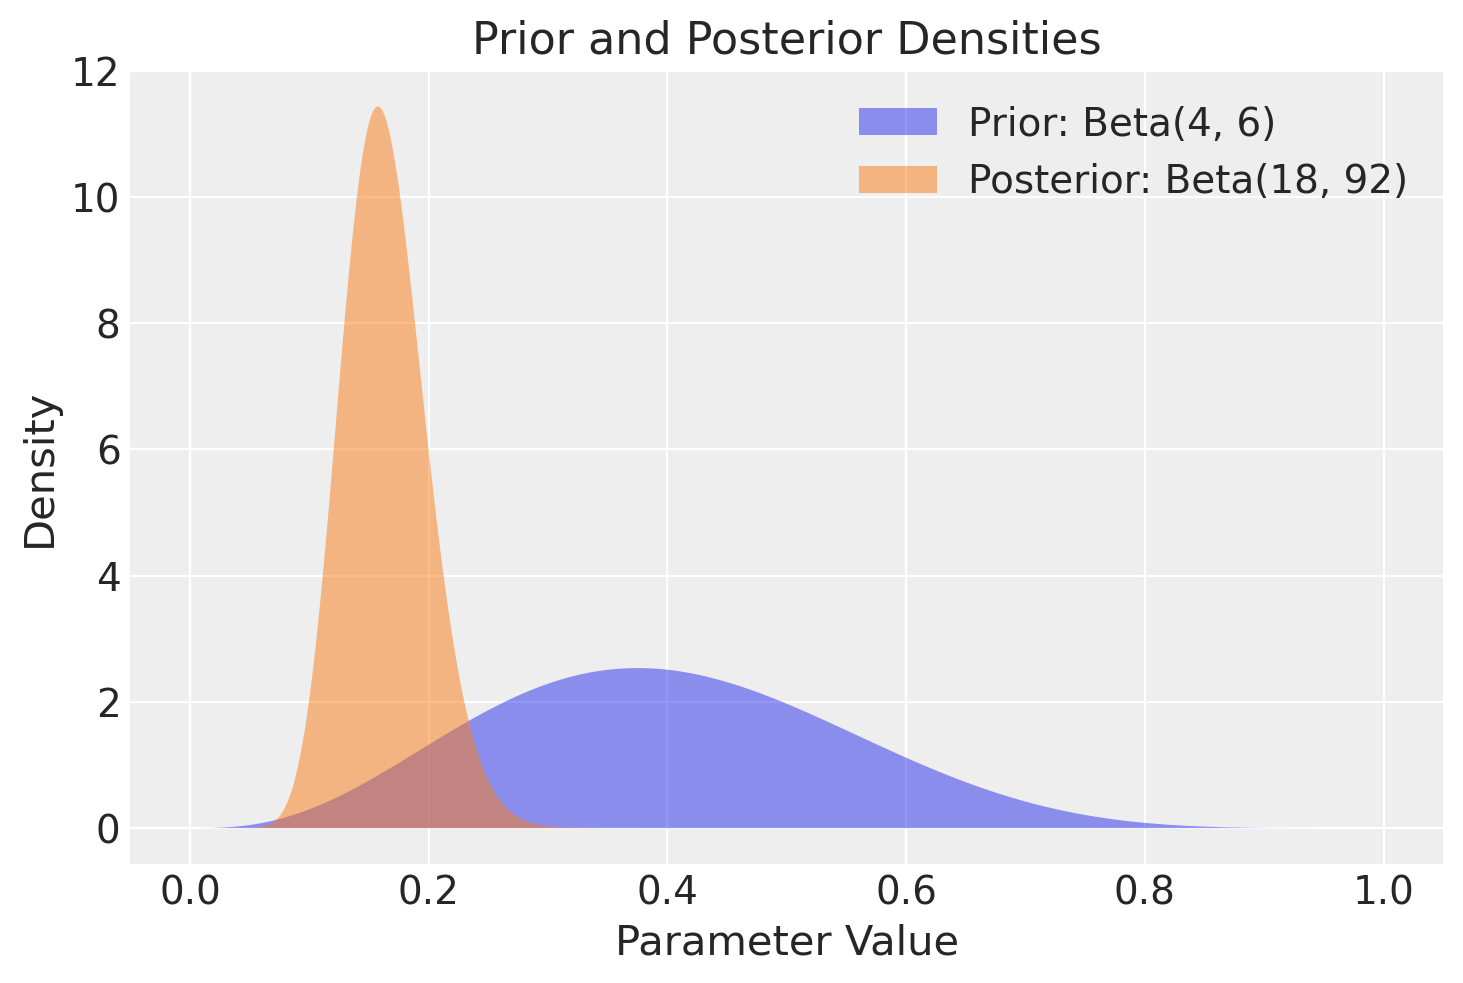

In [7]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)
posterior_density = stats.beta.pdf(x, 18, 92)

plt.fill_between(x, prior_density, alpha=0.5, label="Prior: Beta(4, 6)")
plt.fill_between(x, posterior_density, alpha=0.5, label="Posterior: Beta(18, 92)")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.title("Prior and Posterior Densities")
plt.show()

In [8]:
y = stats.beta(18, 92).rvs(10)
print(*y)

0.1081709752273159 0.13294356199367602 0.16169158948905948 0.13466490995446498 0.15600056580137678 0.11882979780874164 0.16052666642024768 0.12607206924212264 0.10542046913583587 0.14821967991792556


In [9]:
y.mean()

0.13525402849907667

In [10]:
stats.beta(18, 92).rvs(10000).mean()

0.16333949378731155

In [11]:
# Proposal distribution
def uniprop(xprev, delta=0.05):
    return xprev + stats.uniform.rvs(loc=-delta, scale=2 * delta)

In [12]:
# Metropolis algorithm 
def metropolis_v1(p, qdraw, nsamp, xinit):
    """
    Implements the Metropolis algorithm for MCMC sampling.

    The function generates `nsamp` samples from a target distribution `p` using 
    the Metropolis algorithm. The algorithm starts with an initial state `xinit` 
    and iteratively applies a proposal mechanism governed by `qdraw` to explore 
    the target distribution.

    Args:
        p (callable): A function representing the target distribution to sample from.
                     Should accept a float or array-like and return the density 
                     (unnormalized is okay) at that point.
                     
        qdraw (callable): A function implementing the proposal mechanism. 
                          Takes the current state (float or array-like) as input 
                          and returns a proposed next state.
                          
        nsamp (int): The number of samples to draw from the target distribution.
        
        xinit (float or array-like): The initial state for the MCMC chain.

    Returns:
        numpy.ndarray: An array of shape (nsamp,) containing samples drawn from the 
        target distribution `p`.

    Example:
        >>> import numpy as np
        >>> from scipy import stats
        >>> target = stats.norm().pdf  # Standard Normal as target
        >>> qdraw = lambda x: x + np.random.normal(0, 1)  # Random-walk Metropolis
        >>> samples = metropolis_v1(target, qdraw, 10000, 0.0)
    """
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star / p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else:
            samples[i] = x_prev
    return samples

In [13]:
# Initialization
init_state = 0.5
n_samples = 100000

In [14]:
# Using Beta(18, 92) as the target distribution
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), uniprop, n_samples, init_state)

In [15]:
print(samps[0:20])

[0.48666877 0.47399628 0.44482888 0.43358537 0.43358537 0.39864103
 0.35606416 0.35606416 0.35606416 0.35606416 0.35606416 0.35606416
 0.34279011 0.34279011 0.30178457 0.27429809 0.27429809 0.27042774
 0.22281273 0.2339417 ]


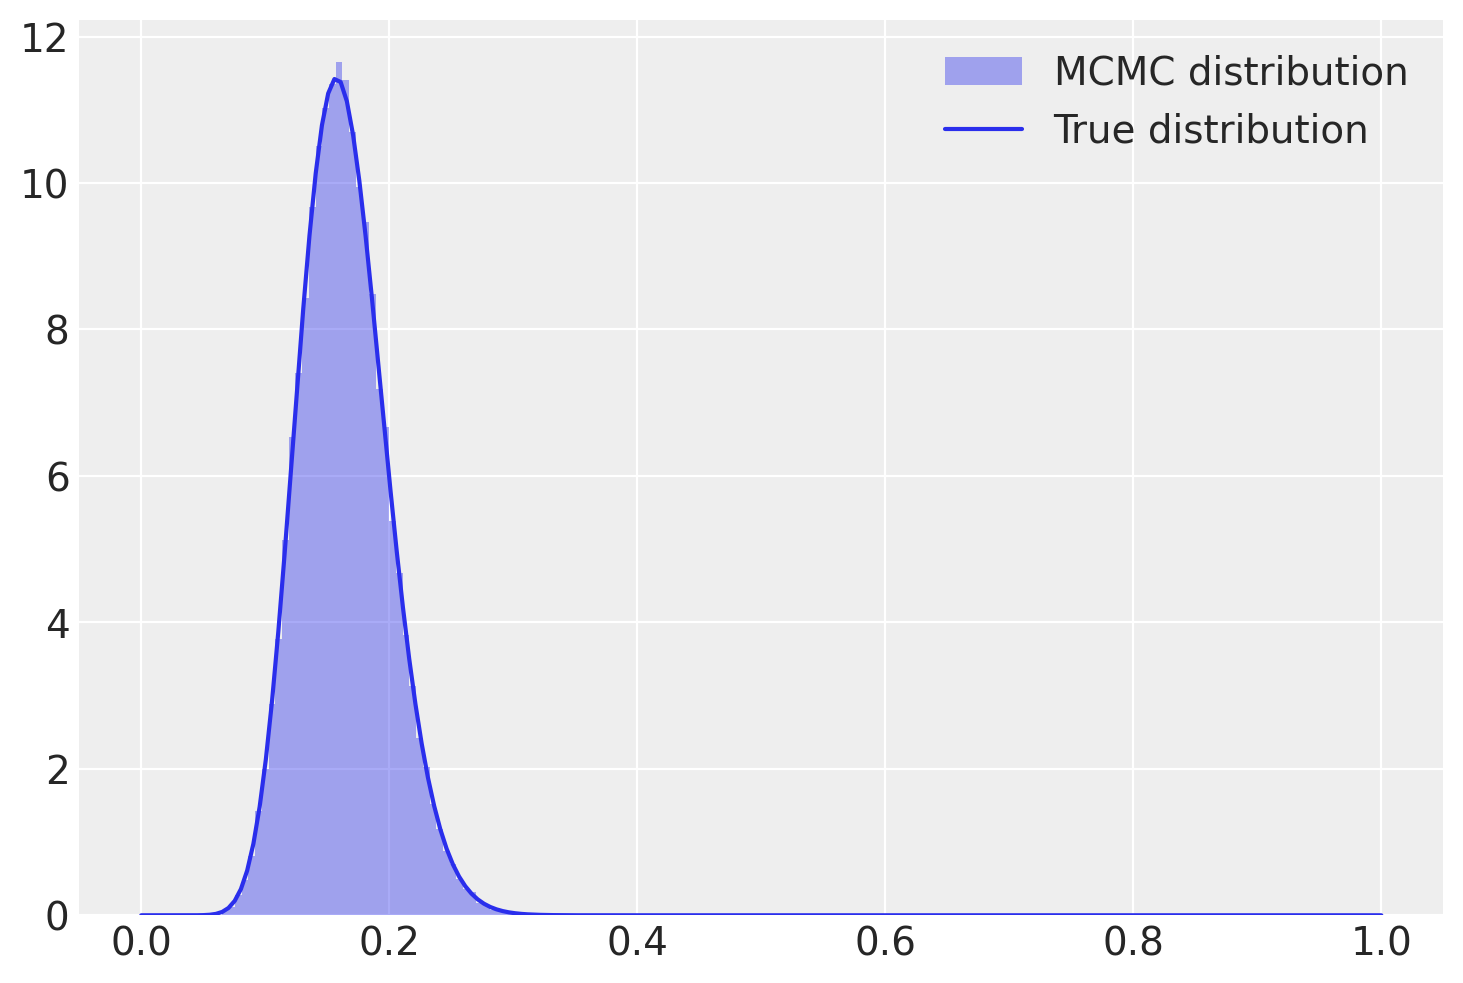

In [16]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 200)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [17]:
# Proposal distribution
def gaussprop(xprev, sigma=0.1):
    return xprev + stats.norm.rvs(scale=sigma)

In [18]:
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), gaussprop, n_samples, init_state)
print(samps[0:20])

[0.5        0.43628202 0.381636   0.381636   0.37674604 0.37674604
 0.37674604 0.37674604 0.3801979  0.38882091 0.38882091 0.38882091
 0.36975219 0.3282116  0.09162112 0.09162112 0.09162112 0.09162112
 0.10159008 0.10159008]


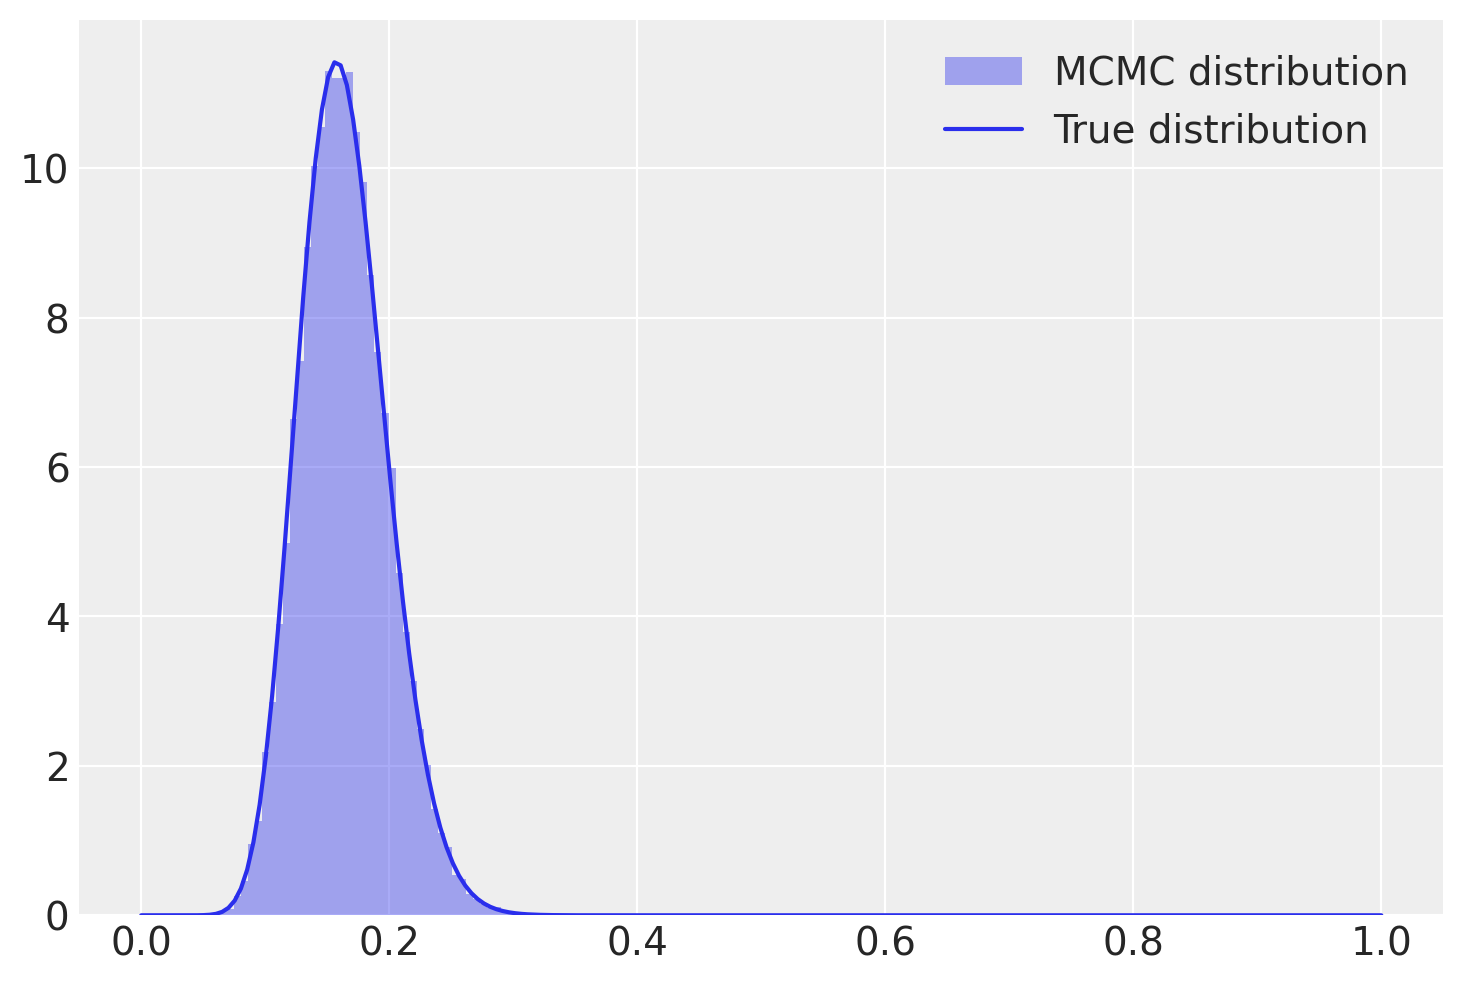

In [19]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 200)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [20]:
def prior(p):
    alpha = 4
    beta = 6
    return stats.beta.pdf(p, alpha, beta)

In [21]:
def likelihood(p):
    y = 14
    n = 100
    return stats.binom.pmf(y, n, p)

In [22]:
def posterior(p):
    return likelihood(p) * prior(p)

In [23]:
def metropolis_v2(p, qdraw, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        # Check that x_star is within the support of the prior and likelihood
        if 0 <= x_star <= 1:
            p_star = p(x_star)
            p_prev = p(x_prev)
            pdfratio = p_star / p_prev if p_prev > 0 else 1

            if np.random.uniform() < min(1, pdfratio):
                samples[i] = x_star
                x_prev = x_star
            else:
                samples[i] = x_prev
        else:
            samples[i] = x_prev  # reject automatically if outside support
    return samples

In [24]:
# Perform Metropolis sampling
samps = metropolis_v2(posterior, lambda x: gaussprop(x, sigma=0.05), n_samples, init_state)

In [25]:
burnin = int(n_samples * 0.5)
burnin

50000

In [26]:
np.mean(samps[burnin:])

0.16402385831329033

In [27]:
np.std(samps[burnin:])

0.035100433152421145

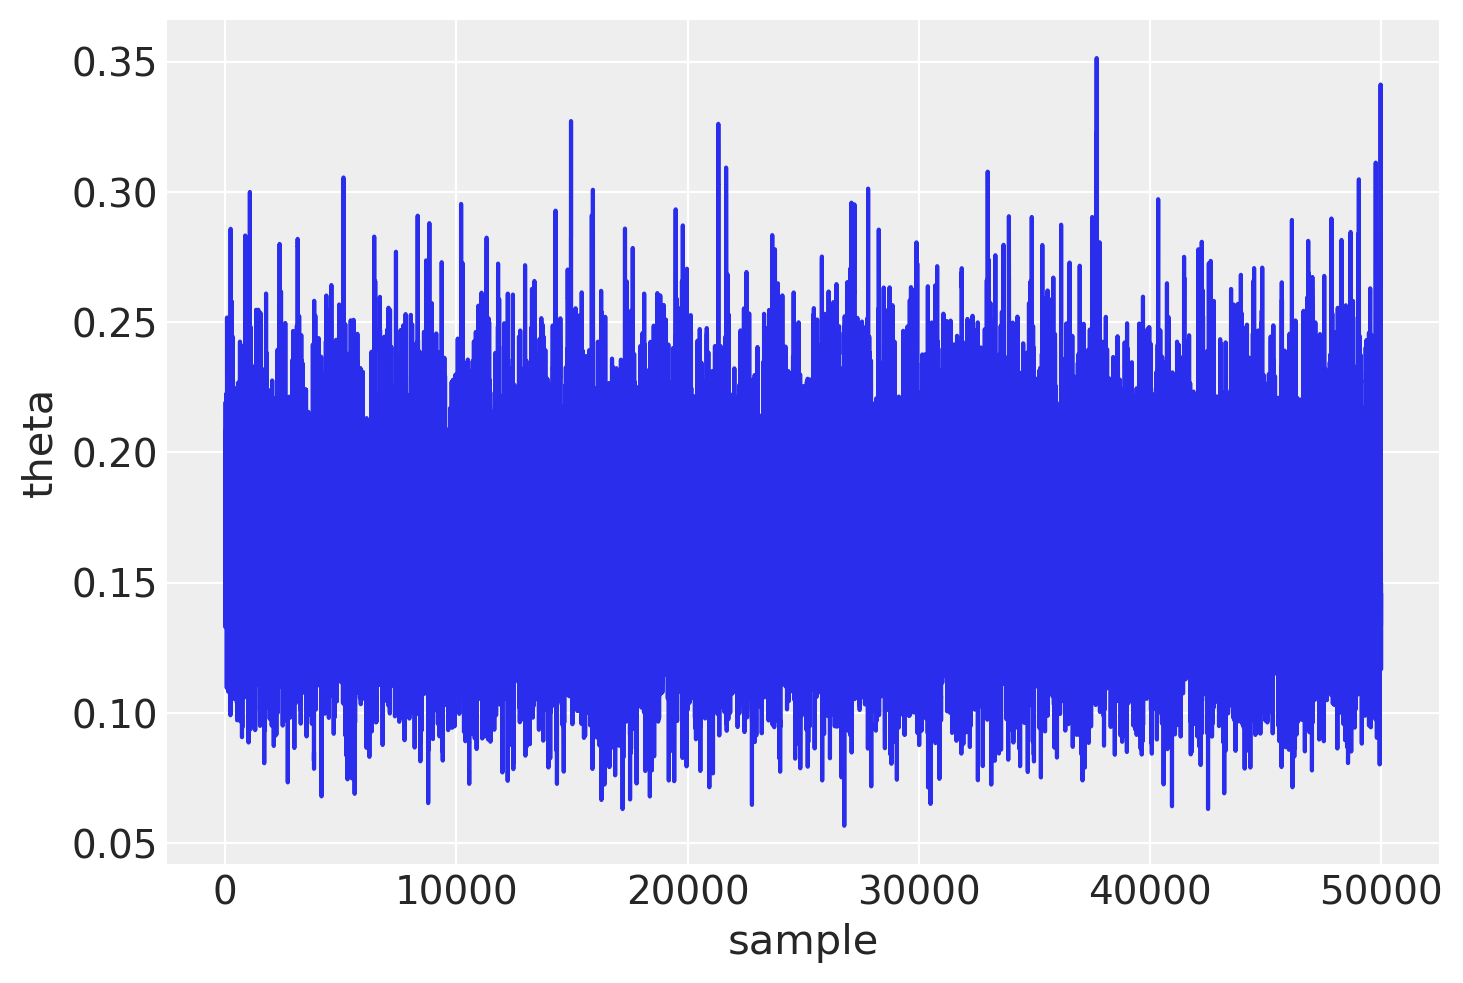

In [28]:
plt.plot(samps[burnin:])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

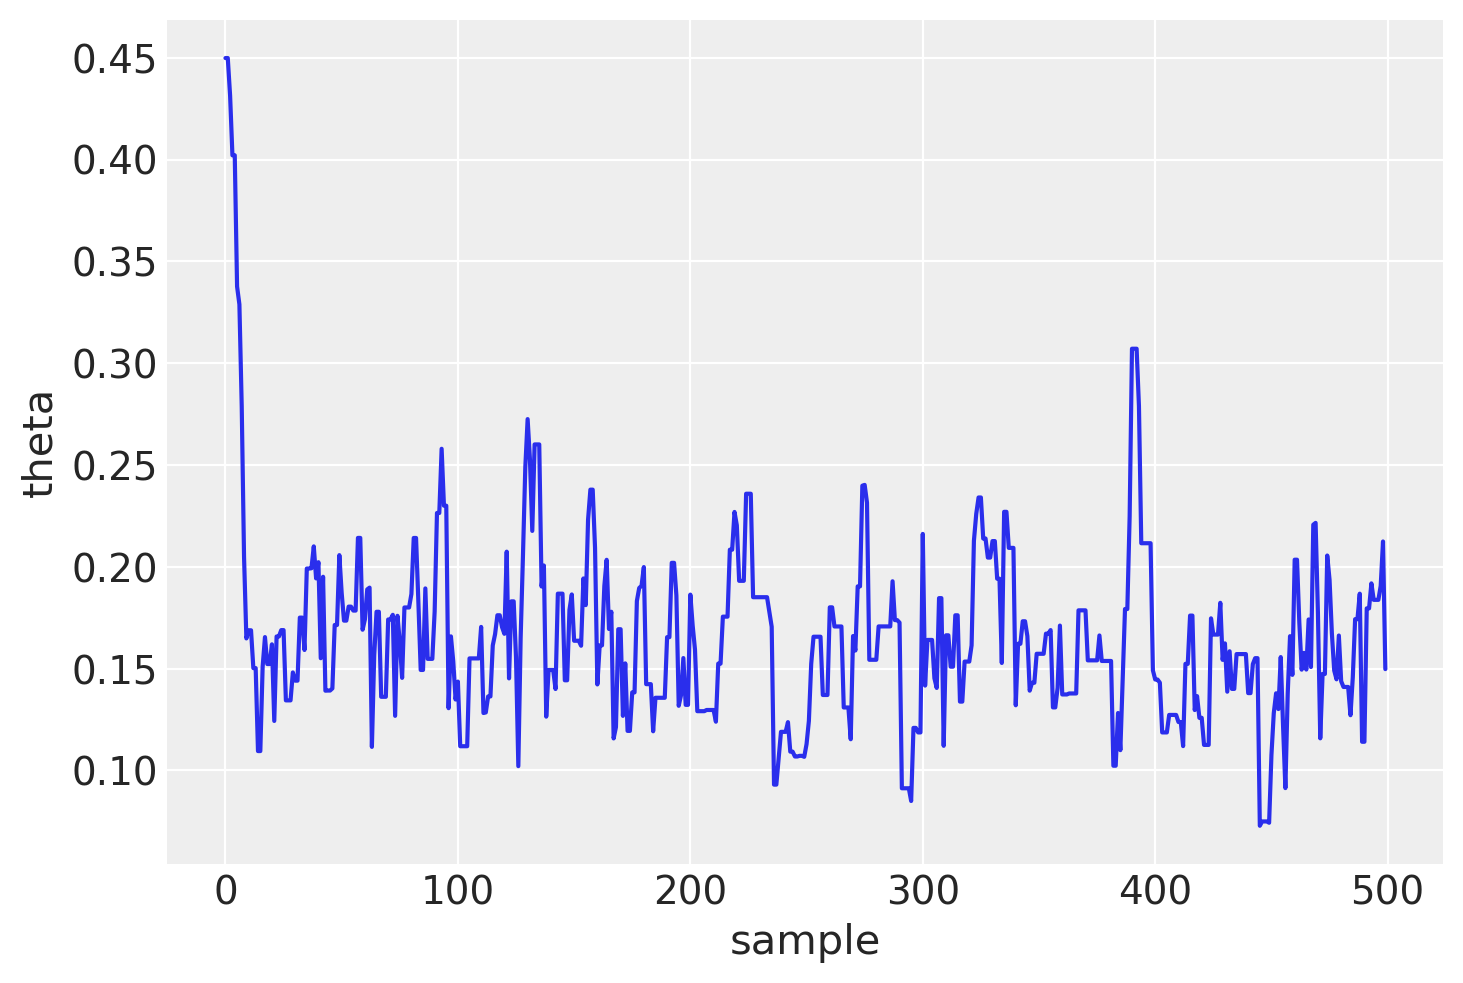

In [29]:
plt.plot(samps[:500])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

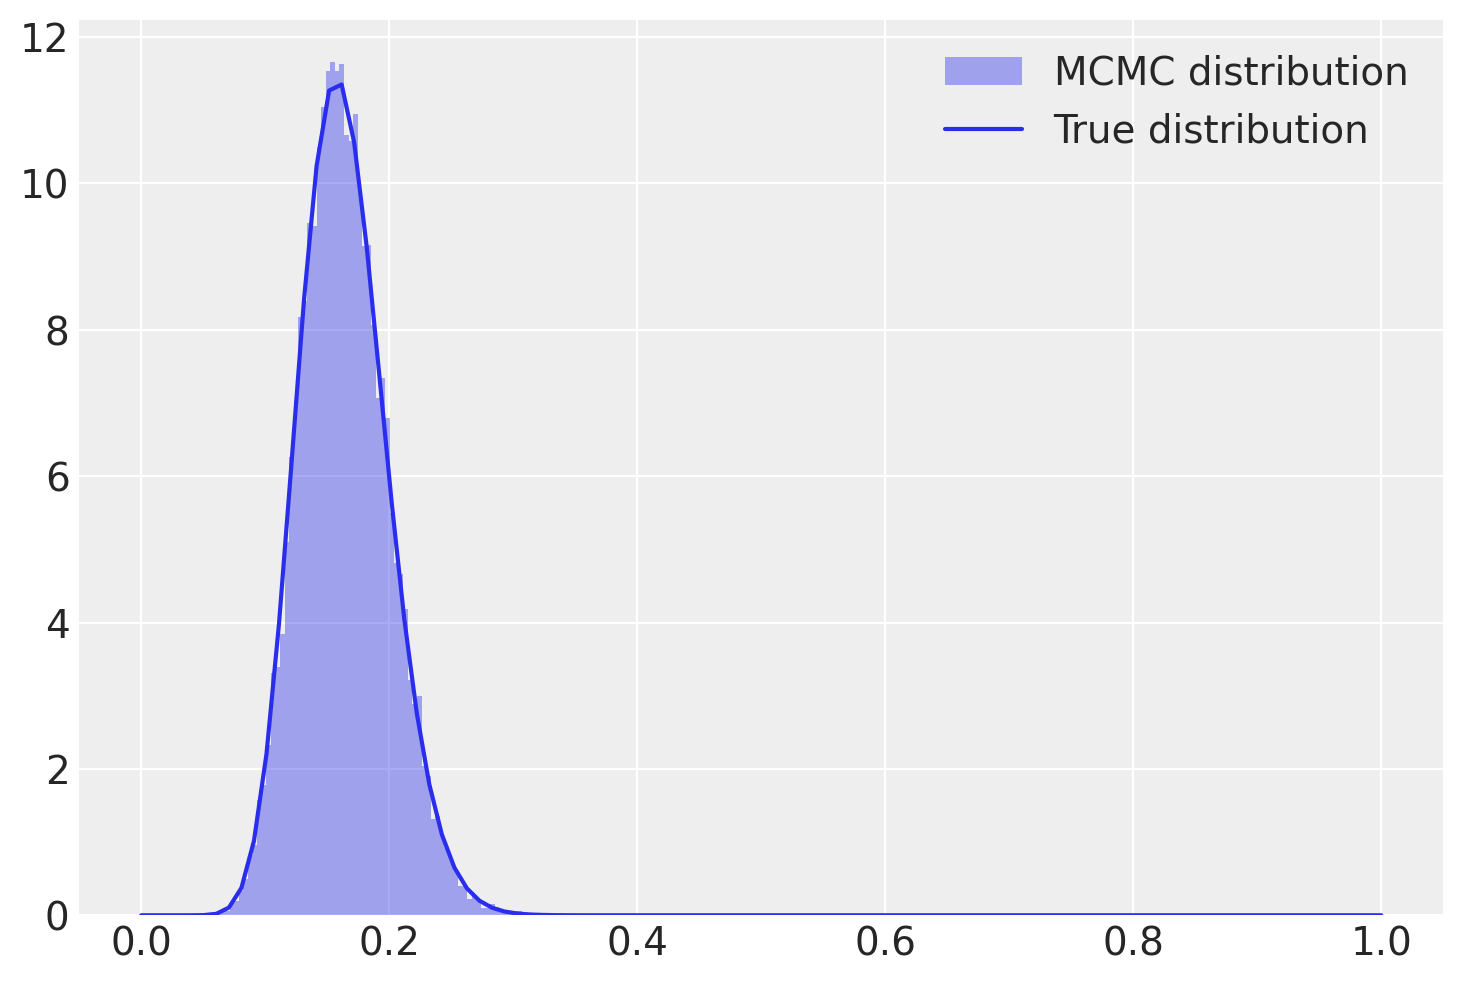

In [30]:
plt.hist(samps[burnin:], bins=80, alpha=0.4, label="MCMC distribution", density=True)
# plot the true function
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [31]:
az.summary(samps[burnin:], kind="stats", hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,0.16,0.04,0.1,0.23


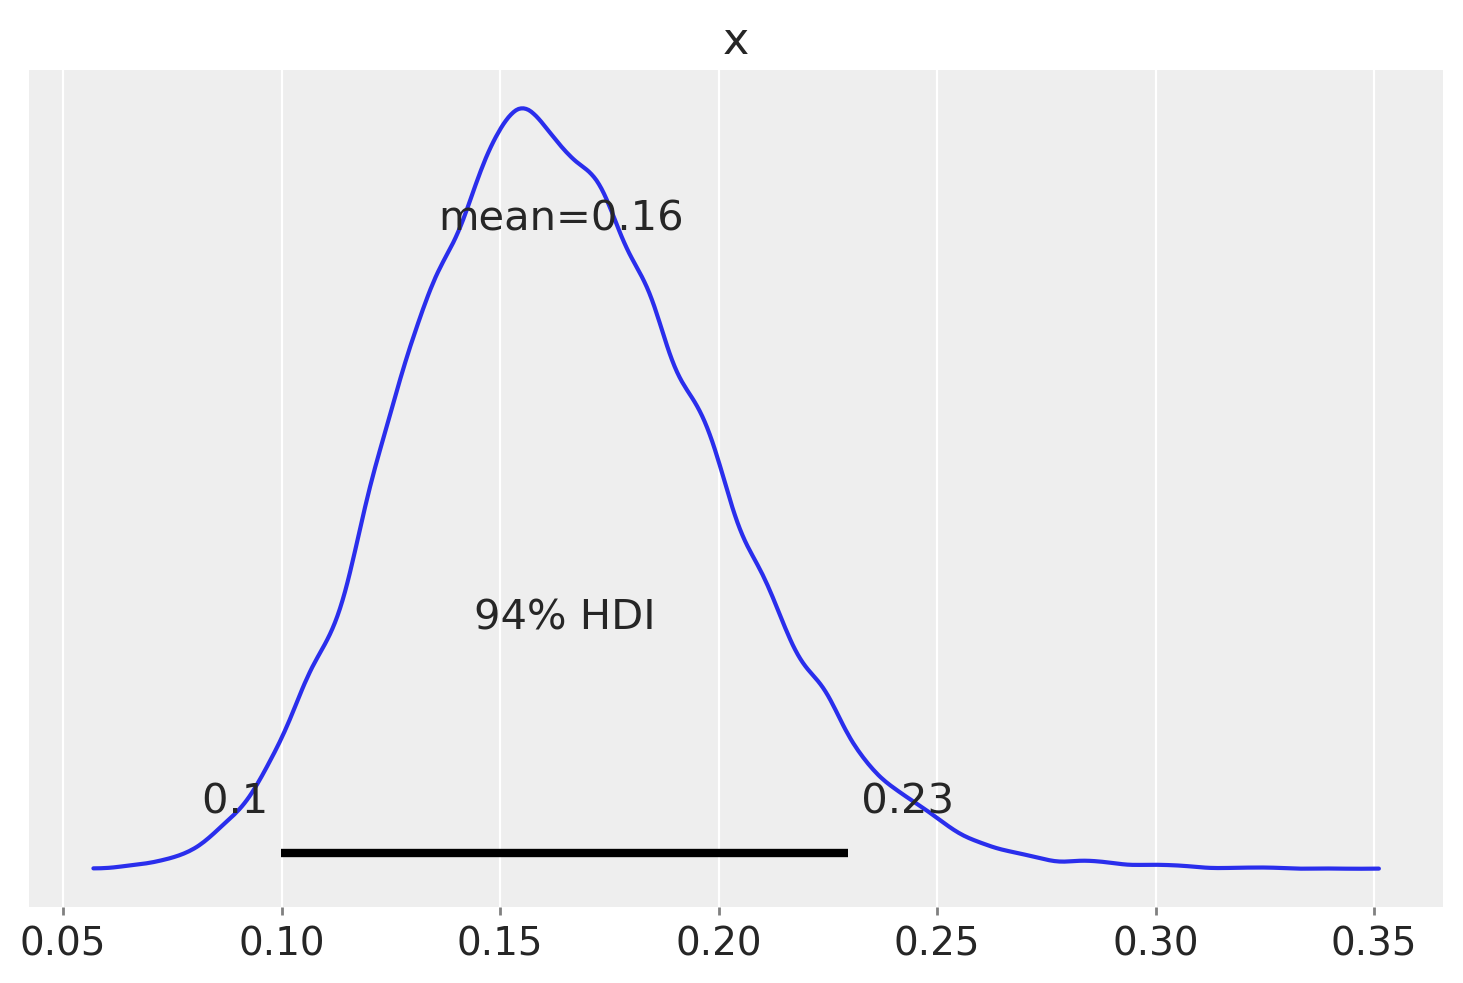

In [32]:
az.plot_posterior(samps[burnin:])
plt.show()

In [33]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(*x)

22 24 25 25 28 29 34 37 40 44 51 48 47 50 51


In [34]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [35]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

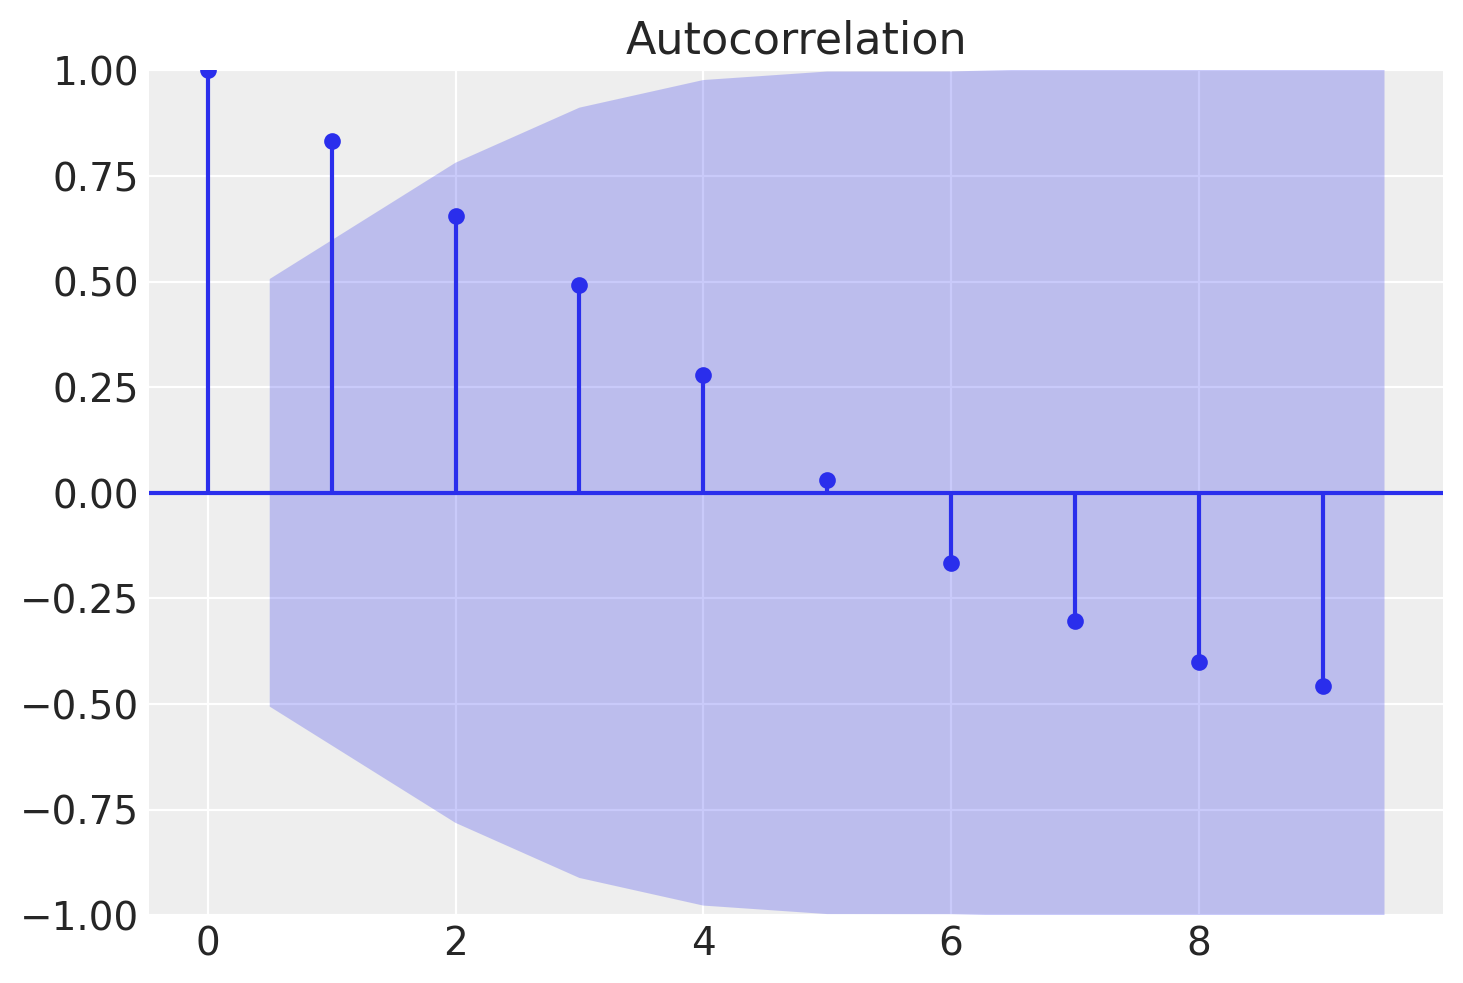

In [36]:
tsaplots.plot_acf(x, lags=9)
plt.show()

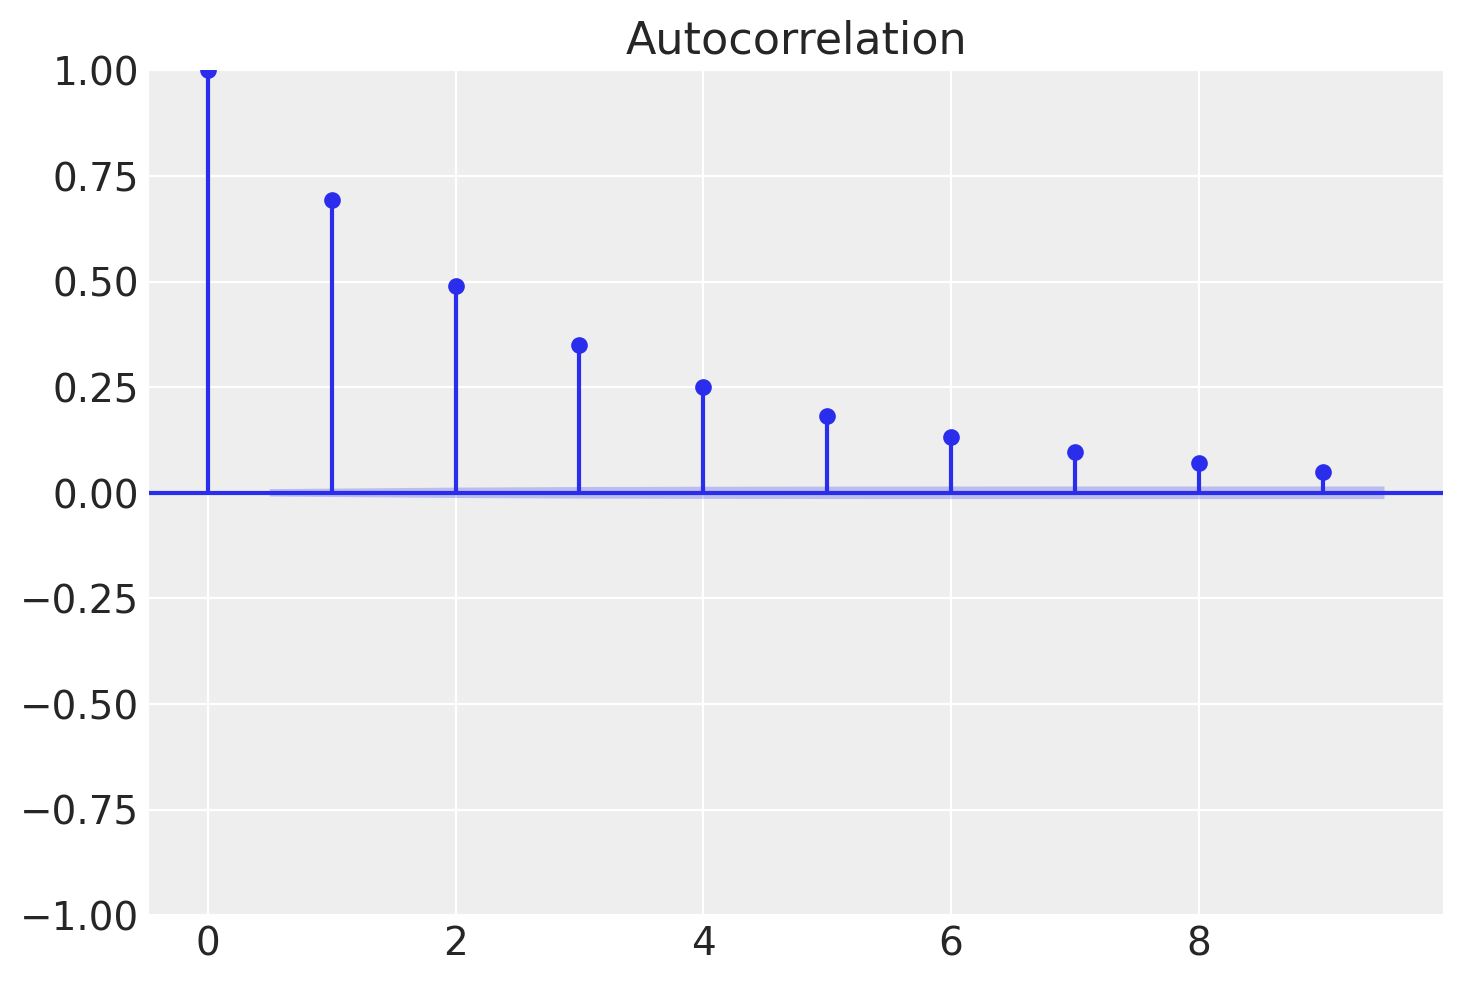

In [37]:
tsaplots.plot_acf(samps[burnin:], lags=9)
plt.show()

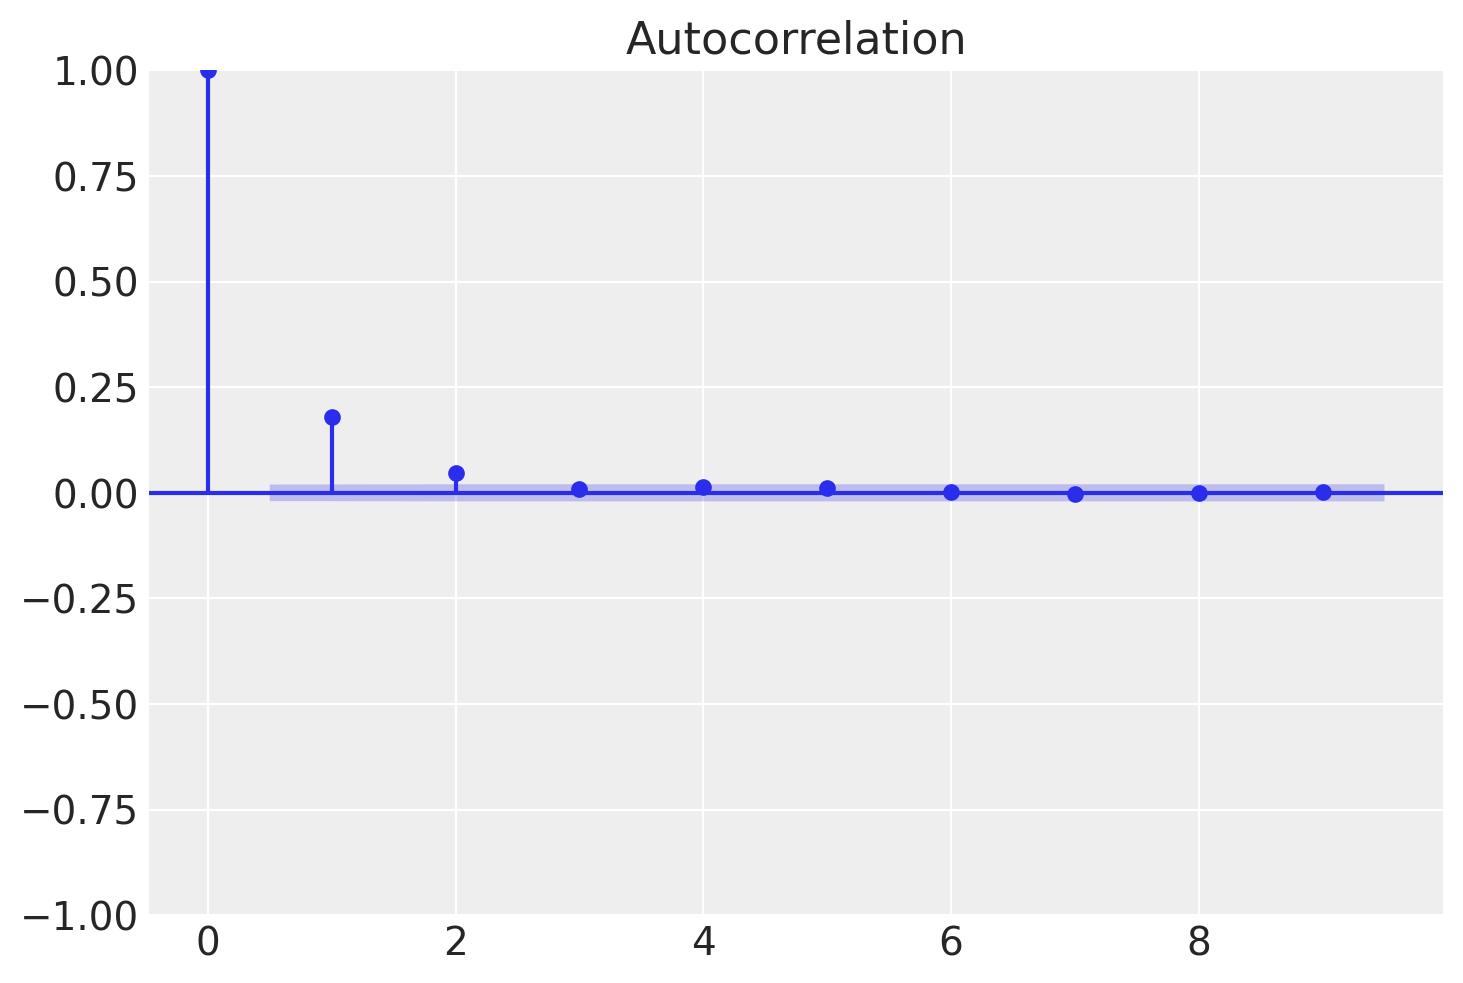

In [38]:
thin=5
sampsthin=samps[burnin::thin]
tsaplots.plot_acf(sampsthin, lags=9)
plt.show()

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 22 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

matplotlib : 3.8.2
arviz      : 0.17.0
numpy      : 1.26.2
seaborn    : 0.13.0
statsmodels: 0.14.1
scipy      : 1.11.4
pandas     : 2.1.4

Watermark: 2.4.3

